[29 残差网络 ResNet](https://www.bilibili.com/video/BV1bV41177ap?spm_id_from=333.999.0.0)
- 我夸我自己
- 加深层数一定会带来更好的结果吗？
- 如果优化的方向错误，那么越优化有可能离最优结果越远
- <img src="picture\屏幕截图 2022-05-16 230430.png"></a>
- 核心思想残差块
- 不预测整个数据，改为预测一阶差分
- <img src="picture\屏幕截图 2022-05-17 003400.png"></a>
- 这里可以看到，并不是直接进行一阶差分，而是增加了一个1X1卷积层变换
- <img src="picture\屏幕截图 2022-05-17 003800.png"></a>
- 同理，残差可以在不同的层输出，从而获得不同的残差块
- 可能是也不知道怎么好，排列组合试一遍
- <img src="picture\屏幕截图 2022-05-17 004306.png"></a>
- ResNet架构
    - 总体而言是类似于VGG和GoogleNet的网络
    - 不过把vgg块替换成resnet块

In [157]:
# 第一步，定义残差块
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

In [158]:
class Residual(nn.Module):
    def __init__(self,input_channels,num_channels,use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, num_channels,kernel_size=3, padding=1, stride=strides)
        self.conv2 = nn.Conv2d(num_channels, num_channels,kernel_size=3, padding=1)
        # 是否对输出使用1X1卷积层
        if use_1x1conv:
            self.conv3 = nn.Conv2d(input_channels, num_channels,kernel_size=1, stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)
        self.relu = nn.ReLU(inplace=True) 
    
    def forward(self,X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        # 这里是核心,输出残差
        # 这里需要注意的是，设计Resnet，Y的shape需要和X保持一致
        Y += X
        return F.relu(Y)


In [159]:
blk = Residual(3,3)
X = torch.rand(4, 3, 6, 6)
Y = blk(X)
Y.shape

torch.Size([4, 3, 6, 6])

In [160]:
X = torch.rand(4, 3, 6, 6)
blk = Residual(3,6, use_1x1conv=True, strides=2)
blk(X).shape

torch.Size([4, 6, 3, 3])

In [161]:
# ResNet模型
# ResNet 的前两层跟之前介绍的GoogLeNet 中的⼀样：在输出通道数为64、步幅为2 的7X7 卷积层后，接
# 步幅为2 的3X3 的最⼤汇聚层。不同之处在于ResNet 每个卷积层后增加了批量归⼀化层。
b1 = nn.Sequential(
    nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
    nn.BatchNorm2d(64), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [162]:
# 这种写法之前比较少见，通过数组的形式添加层，在直接*args添加进Sequential
def resnet_block(input_channels, num_channels, num_residuals,first_block=False):
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.append(Residual(input_channels, num_channels,use_1x1conv=True, strides=2))
        else:
            blk.append(Residual(num_channels, num_channels))
    return blk

In [163]:
b2 = nn.Sequential(*resnet_block(64, 64, 2, first_block=True))
b3 = nn.Sequential(*resnet_block(64, 128, 2))
b4 = nn.Sequential(*resnet_block(128, 256, 2))
b5 = nn.Sequential(*resnet_block(256, 512, 2))

In [164]:
net = nn.Sequential(b1, b2, b3, b4, b5,
    nn.AdaptiveAvgPool2d((1,1)),
    nn.Flatten(), nn.Linear(512, 10))

In [165]:
X = torch.rand(size=(1, 1, 224, 224))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 64, 56, 56])
Sequential output shape:	 torch.Size([1, 64, 56, 56])
Sequential output shape:	 torch.Size([1, 128, 28, 28])
Sequential output shape:	 torch.Size([1, 256, 14, 14])
Sequential output shape:	 torch.Size([1, 512, 7, 7])
AdaptiveAvgPool2d output shape:	 torch.Size([1, 512, 1, 1])
Flatten output shape:	 torch.Size([1, 512])
Linear output shape:	 torch.Size([1, 10])


loss 0.016, train acc 0.996, test acc 0.908
5084.6 examples/sec on cuda:0


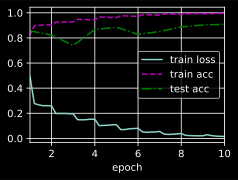

In [166]:
lr, num_epochs, batch_size = 0.05, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

Q/A
- Q: 为什么使用残差就能够使得效果更好？按理来说也有可能变坏
    - A：如果训练效果很好，相对应的差值也会小，对应梯度也会小， 参数将更新缓慢或者不更新，因此模型很难变坏

[29.2 ResNet为什么能训练出1000层的模型](https://www.bilibili.com/video/BV1554y157E3/?spm_id_from=333.788.recommend_more_video.1)

- resnet为什么能够训练1000层深度，而梯度不会消失？
- <img src="picture\屏幕截图 2022-05-18 002824.png"></a>
- <img src="picture\屏幕截图 2022-05-18 003320.png"></a>
- <img src="picture\屏幕截图 2022-05-18 003555.png"></a>
